# Housing Price Prediction: Multi Input Neural Network

## COMP 4449 Capstone
Rodney Cordova

## Import modules

In [1]:
import numpy as np 
import pandas as pd 
import requests 
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import glob
import cv2
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import shutil
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import concatenate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import locale

## Loan Numeric Data

In [2]:
file = os.getcwd()+"/house_image_data"+"/house_pricing.csv"
df = pd.read_csv(file)
df.drop(columns = ["id"], inplace=True)
df.head(10)

,Bedrooms,Bathrooms,sqft,Price
0,4,3,1634,452000
1,4,3,2037,450000
2,4,3,1879,495000
3,4,2,1976,498900
4,3,2,1667,450000
5,3,2,1732,470000
6,3,3,1522,455000
7,4,3,2137,479900
8,4,4,1978,479000
9,4,4,3610,692200


## Load Image Data

In [3]:
image_path = os.getcwd()+"/house_image_data"
images = [] 

for i in df.index.values: 
    house_images = os.path.sep.join([image_path, "{}-*".format(i + 1)])
    images_paths = sorted(list(glob.glob(house_images)))
    inputImages = []
    outputImage = np.zeros((64, 64, 3), dtype="uint8")
    
    for j in images_paths:
        image = cv2.imread(j)
        image = cv2.resize(image, (32, 32))
        inputImages.append(image)
    
    outputImage[0:32, 0:32] = inputImages[0]
    outputImage[0:32, 32:64] = inputImages[1]
    outputImage[32:64, 32:64] = inputImages[2]
    outputImage[32:64, 0:32] = inputImages[3]
    
    images.append(outputImage)

images = np.array(images)

## EDA 

In [4]:
#numberical data summary
df.describe()

,Bedrooms,Bathrooms,sqft,Price
count,639.000000,639.000000,639.000000,639.000000
mean,3.721440,2.888889,2354.095462,602101.237872
std,0.938898,0.972273,933.326090,165022.828003
min,1.000000,1.000000,487.000000,209900.000000
25%,3.000000,2.000000,1707.000000,475000.000000
50%,4.000000,3.000000,2207.000000,570000.000000
75%,4.000000,4.000000,2883.000000,725000.000000
max,6.000000,6.000000,7323.000000,999999.000000


/home/rdcord/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Price'>

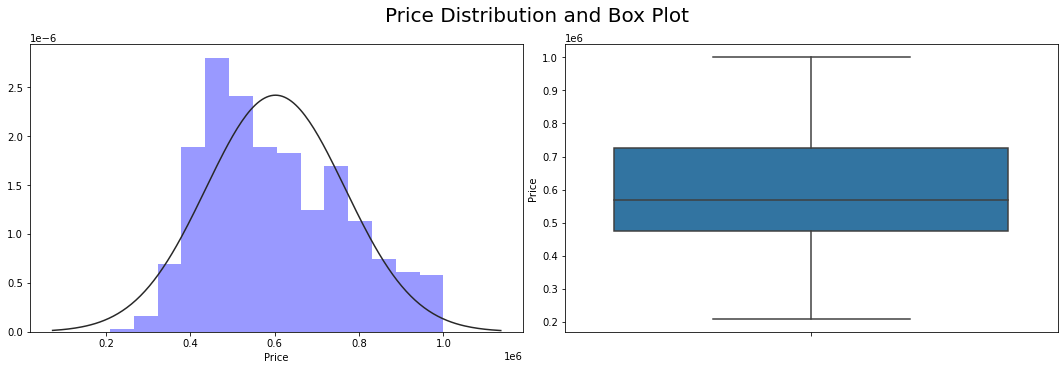

In [5]:
#access price distribution 
fig, axes = plt.subplots(1,2, figsize = (15,5))
plt.suptitle("Price Distribution and Box Plot", size=20)
plt.tight_layout()
sns.distplot(df['Price'],fit= norm,kde=False, color="b",ax=axes[0])
sns.boxplot(y='Price',data=df)

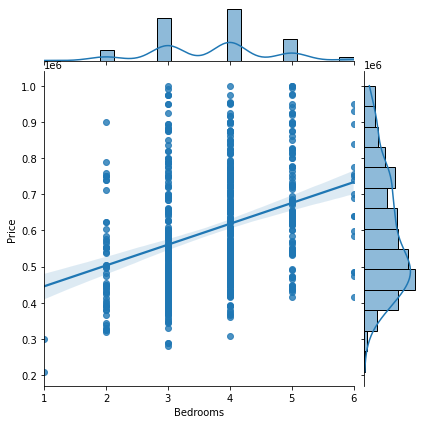

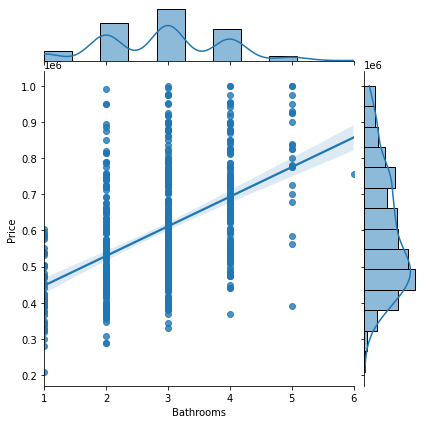

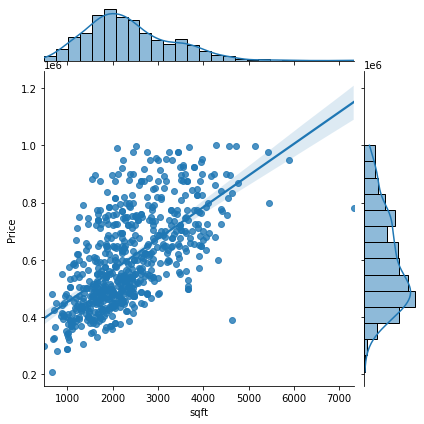

In [6]:
#access price vs the other numeric features
features = ["Bedrooms", "Bathrooms", "sqft"]
for i in features:
    sns.jointplot(data = df, x = i, y = "Price",kind="reg")

<AxesSubplot:>

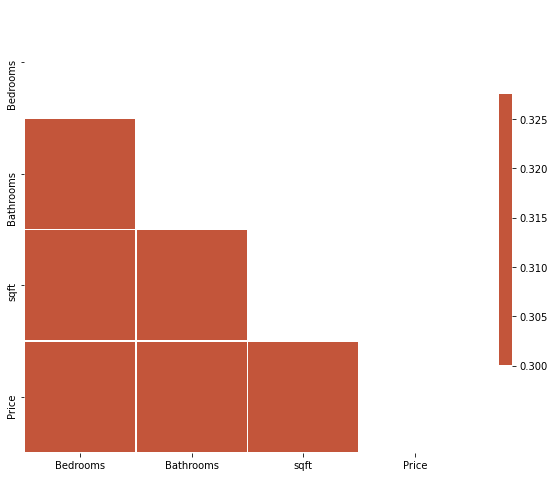

In [7]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [8]:
#checking for outliers
for i in df: 
    outliers = df[df[i] > df[i].mean() + 3 * df[i].std()]
    print("{}: {}".format(i,outliers.shape[0]))

Bedrooms: 0
Bathrooms: 1
sqft: 4
Price: 0


## Feature Engineering

In [9]:
#feature scaling
features = ["Bedrooms","Bathrooms","sqft"]
minMax = MinMaxScaler()
scaledNumeric = minMax.fit_transform(df[features])


In [10]:
split = train_test_split(df, images, test_size=0.20, random_state=42)
(x_train_num, x_test_num, x_train_img, x_test_img) = split

In [11]:
#built image generator
datagen = ImageDataGenerator(
        rotation_range=0.2,
        width_shift_range=0.3,
        height_shift_range=0.3,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest')

In [12]:
#generate and save images
folder = os.getcwd()+"/house_gen_data"
batches = 30

for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))
            
while len([name for name in os.listdir(folder) if os.path.isfile(os.path.join(folder, name))]) != (len(x_train_img)*batches):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
    aug = 0
    for i in x_train_img:  
        count = 0
        pic_array = i.reshape((1,) + i.shape)
        it = datagen.flow(pic_array, 
                          batch_size=1,
                          shuffle=False,
                          save_to_dir=os.getcwd()+"/house_gen_data",
                          seed = 42,
                          save_prefix=aug, 
                          save_format='jpeg')
        for i in range(batches):
            batch = it.next()
        aug += 1


In [13]:
#load new test images
x_train_num = x_train_num.reset_index(drop = True)
image_path = os.getcwd()+"/house_gen_data"
images_test = [] 

for i in x_train_num.index.values:
    house_images = os.path.sep.join([image_path, "{}_0*".format(i)])
    images_paths = sorted(list(glob.glob(house_images)))
    
    for j in images_paths:
        image = cv2.imread(j)
        images_test.append(image)
x_train_img = np.array(images_test)

In [14]:
#expand numeric train data
x_train_num = pd.DataFrame(np.repeat(x_train_num.values, 30, axis=0), columns=df.columns)

In [15]:
#validate the dimensions of image and numeric dfs match
len(x_train_img) == len(x_train_num)

True

In [16]:
maxPrice = x_train_num["Price"].max() 
#final training datasets
y_train = x_train_num['Price'] 
x_train_num = x_train_num.drop(columns = ["Price"]) 

#final testing datasets
y_test = x_test_num['Price'] 
x_test_num = x_test_num.drop(columns = ["Price"])

print(y_train.shape)
print(x_test_img.shape)
print(x_train_num.shape)
print(y_test.shape)
print(x_test_num.shape)

(15330,)
(128, 64, 64, 3)
(15330, 3)
(128,)
(128, 3)


## Neural Network

In [17]:
#multi-payer perceptron 
def create_mlp(dim, regress=False):
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(4, activation="relu"))

    if regress:
        model.add(Dense(1, activation="linear"))

    return model

In [18]:
#CNN
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    inputShape = (height, width, depth)
    chanDim = -1

    inputs = Input(shape=inputShape)
    for (i, f) in enumerate(filters):
        if i == 0:
            x = inputs
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
    x = Dense(4)(x)
    x = Activation("relu")(x)

    if regress:
        x = Dense(1, activation="linear")(x)

    model = Model(inputs, x)
    return model


In [19]:
mlp = create_mlp(x_train_num.shape[1], regress=False)
cnn = create_cnn(64, 64, 3, regress=False)

In [20]:
combinedInput = concatenate([mlp.output, cnn.output])

In [21]:
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

In [22]:
model = Model(inputs=[mlp.input, cnn.input], outputs=x)
opt = Adam(lr=0.1)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)
model.fit(
    x=[x_train_num, x_train_img], y=y_train,
    validation_data=([x_test_num, x_test_img], y_test),epochs=50, batch_size=10)

Epoch 1/50
1533/1533 [==============================] - 23s 15ms/step - loss: 19.9980 - val_loss: 16.8885
Epoch 2/50
1533/1533 [==============================] - 22s 15ms/step - loss: 18.8256 - val_loss: 19.9691
Epoch 3/50
1533/1533 [==============================] - 23s 15ms/step - loss: 18.6989 - val_loss: 18.0171
Epoch 4/50
1533/1533 [==============================] - 23s 15ms/step - loss: 18.1164 - val_loss: 19.0257
Epoch 5/50
1533/1533 [==============================] - 22s 15ms/step - loss: 17.8239 - val_loss: 16.9313
Epoch 6/50
1533/1533 [==============================] - 23s 15ms/step - loss: 17.3279 - val_loss: 16.2533
Epoch 7/50
1533/1533 [==============================] - 22s 14ms/step - loss: 16.3267 - val_loss: 16.2084
Epoch 8/50
1533/1533 [==============================] - 22s 14ms/step - loss: 15.7004 - val_loss: 16.8804
Epoch 9/50
1533/1533 [==============================] - 21s 14ms/step - loss: 15.4514 - val_loss: 16.1590
Epoch 10/50
1533/1533 [=======================

In [24]:
y_pred = model.predict([x_test_num, x_test_img])
diff = y_pred.flatten() - y_test
percentDiff = (diff / y_test) * 100
absPercentDiff = np.abs(percentDiff)

mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("avg. house price: {}, std house price: {}".format(
    locale.currency(df["Price"].mean(), grouping=True),
    locale.currency(df["Price"].std(), grouping=True)))
print("mean: {:.2f}%, std: {:.2f}%".format(mean, std))

avg. house price: $602,101.24, std house price: $165,022.83
mean: 22.06%, std: 16.54%


In [ ]:
#optimize batch size and epocs
batch_size = [10,30,50,75,100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)

x=[x_train_num, x_train_img]
y=y_train

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error',n_jobs=-1, cv=3)
grid_result = grid.fit(x, y)

In [25]:
#optimize batch size 
batch_size = [10,30,50,75,100]
batch_results = []

for batch in batch_size:
    model = Model(inputs=[mlp.input, cnn.input], outputs=x)
    opt = Adam(lr=0.1)
    model.compile(loss="mean_absolute_percentage_error", optimizer=opt)
    model.fit(
        x=[x_train_num, x_train_img], y=y_train,
        validation_data=([x_test_num, x_test_img], y_test),epochs=50, batch_size=batch,verbose=0)
    y_pred = model.predict([x_test_num, x_test_img])
    diff = y_pred.flatten() - y_test
    percentDiff = (diff / y_test) * 100
    absPercentDiff = np.abs(percentDiff)
    mean = np.mean(absPercentDiff)
    batch_results.append((batch,mean))

batch_results

[(10, 19.243985489852875),
 (30, 19.326586842488773),
 (50, 20.19228898015664),
 (75, 22.026288941389932),
 (100, 21.9806341506105)]

In [27]:
#optimize epochs
epochs = [50, 100, 200]
epochs_results = []

for epoch in epochs:
    model = Model(inputs=[mlp.input, cnn.input], outputs=x)
    opt = Adam(lr=0.1)
    model.compile(loss="mean_absolute_percentage_error", optimizer=opt)
    model.fit(
        x=[x_train_num, x_train_img], y=y_train,
        validation_data=([x_test_num, x_test_img], y_test),epochs=epoch, batch_size=10,verbose=0)
    y_pred = model.predict([x_test_num, x_test_img])
    diff = y_pred.flatten() - y_test
    percentDiff = (diff / y_test) * 100
    absPercentDiff = np.abs(percentDiff)
    mean = np.mean(absPercentDiff)
    epochs_results.append((epoch,mean))
    
epochs_results

[(50, 20.461824760287044),
 (100, 22.948603118980863),
 (200, 25.470108602311335)]

In [30]:
learn_rate = [0.001, 0.01, 0.1, 0.3, 0.5]
learn_rate_results = []

for rate in learn_rate:
    model = Model(inputs=[mlp.input, cnn.input], outputs=x)
    opt = Adam(lr=rate)
    model.compile(loss="mean_absolute_percentage_error", optimizer=opt)
    model.fit(
        x=[x_train_num, x_train_img], y=y_train,
        validation_data=([x_test_num, x_test_img], y_test),epochs=50, batch_size=10,verbose=0)
    y_pred = model.predict([x_test_num, x_test_img])
    diff = y_pred.flatten() - y_test
    percentDiff = (diff / y_test) * 100
    absPercentDiff = np.abs(percentDiff)
    mean = np.mean(absPercentDiff)
    learn_rate_results.append((rate,mean))
    
learn_rate_results

[(0.001, 27.391673042014048),
 (0.01, 27.377773831960184),
 (0.1, 28.24556640116429),
 (0.3, 30.519138754637957),
 (0.5, 29.066305068942068)]

In [24]:
model = Model(inputs=[mlp.input, cnn.input], outputs=x)
opt = Adam(lr=0.1)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)
history = model.fit(
    x=[x_train_num, x_train_img], y=y_train,
    validation_data=([x_test_num, x_test_img], y_test),epochs=50, batch_size=10)

Epoch 1/50
1533/1533 [==============================] - 21s 14ms/step - loss: 13.1124 - val_loss: 15400.7930
Epoch 2/50
1533/1533 [==============================] - 21s 13ms/step - loss: 12.9131 - val_loss: 13646.4033
Epoch 3/50
1533/1533 [==============================] - 21s 14ms/step - loss: 13.0545 - val_loss: 14776.8789
Epoch 4/50
1533/1533 [==============================] - 21s 13ms/step - loss: 12.7600 - val_loss: 14407.6475
Epoch 5/50
 313/1533 [=====>........................] - ETA: 16s - loss: 13.0432

KeyboardInterrupt: 

In [ ]:
#save final model 
history.save(os.getcwd())

In [ ]:
y_pred = history.predict([x_test_num, x_test_img])
diff = y_pred.flatten() - y_test
percentDiff = (diff / y_test) * 100
absPercentDiff = np.abs(percentDiff)

mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("avg. house price: {}, std house price: {}".format(
    locale.currency(df["Price"].mean(), grouping=True),
    locale.currency(df["Price"].std(), grouping=True)))
print("mean: {:.2f}%, std: {:.2f}%".format(mean, std))

In [23]:
#save final model 
model.save(os.getcwd())

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /mnt/c/Users/Rodney-PC/OneDrive/Desktop/Scripts/COMP 4447/dst1-env/COMP 4449/assets


In [ ]:
print(history.history.keys())

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
from tensorflow import keras
history = keras.models.load_model(os.getcwd())

In [31]:
y_pred = history.predict([x_test_num, x_test_img])
diff = y_pred.flatten() - y_test
percentDiff = (diff / y_test) * 100
absPercentDiff = np.abs(percentDiff)

mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("avg. house price: {}, std house price: {}".format(
    locale.currency(df["Price"].mean(), grouping=True),
    locale.currency(df["Price"].std(), grouping=True)))
print("mean: {:.2f}%, std: {:.2f}%".format(mean, std))

avg. house price: $602,101.24, std house price: $165,022.83
mean: 19.71%, std: 12.72%


In [54]:
x_test = np.array(x_test_num)
x_train = np.array(x_train_num)


In [64]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

In [66]:
regr = make_pipeline(SVR(C=1.0, epsilon=0.2))
regr.fit(x_train_num, y_train)

Pipeline(steps=[('svr', SVR(epsilon=0.2))])

In [68]:
svr_pred = regr.predict(x_test_num)

In [69]:
diff = svr_pred.flatten() - y_test
percentDiff = (diff / y_test) * 100
absPercentDiff = np.abs(percentDiff)

mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("avg. house price: {}, std house price: {}".format(
    locale.currency(df["Price"].mean(), grouping=True),
    locale.currency(df["Price"].std(), grouping=True)))
print("mean: {:.2f}%, std: {:.2f}%".format(mean, std))

avg. house price: $602,101.24, std house price: $165,022.83
mean: 24.49%, std: 16.24%
